In [13]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain_core.runnables import Runnable
import pandas as pd
from langchain.tools.retriever import create_retriever_tool
from langgraph.prebuilt import ToolNode
import torch
from langchain.chat_models import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from transformers import AutoModelForCausalLM, AutoTokenizer, TextIteratorStreamer
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools.retriever import create_retriever_tool

from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
import json
from pydantic import BaseModel, Field
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel, Field



모델 지정 

In [47]:
model_name = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"
#model_name = "naver-hyperclovax/HyperCLOVAX-SEED-Text-Instruct-1.5B"
streaming = True    # choose the streaming option

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### **VectorDB 생성**

pdfplumber

In [39]:
import pdfplumber
from langchain_core.documents import Document

def load_pdf_with_tables(filepath: str):
    documents = []

    with pdfplumber.open(filepath) as pdf:
        for page_num, page in enumerate(pdf.pages):
            # 일반 텍스트 추출
            text = page.extract_text()
            if text:
                documents.append(Document(
                    page_content=text,
                    metadata={"source": filepath, "page": page_num + 1, "type": "text"}
                ))

            # 표 추출
            tables = page.extract_tables()
            for idx, table in enumerate(tables):
                # 표는 2D 리스트 → 문자열로 변환
                table_str = "\n".join(["\t".join([cell if cell is not None else "" for cell in row]) for row in table])

                documents.append(Document(
                    page_content=table_str,
                    metadata={"source": filepath, "page": page_num + 1, "type": "table"}
                ))

    return documents

documents = load_pdf_with_tables('/mnt/ssd/1/jyoung/rag_nodes/iljoo_faq.pdf')

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


UnstructuredPDF

In [17]:
from llama_index.core.schema import Document as LlamaDocument
from langchain_community.document_loaders import UnstructuredPDFLoader
from llama_index.core import Settings,VectorStoreIndex, ServiceContext
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.vector_stores.faiss import FaissVectorStore
from llama_index.core.storage.storage_context import StorageContext
import os

os.environ["OCR_AGENT"] = "tesseract"

lc_docs = UnstructuredPDFLoader("/mnt/ssd/1/jyoung/rag_nodes/iljoo_faq.pdf", mode="elements").load()
# LangChain Document → LlamaIndex Document 변환
llama_docs = [Document(page_content=doc.page_content, metadata=doc.metadata) for doc in lc_docs]

# 2. 청킹 (Character 기반으로 쪼갬)
text_splitter = CharacterTextSplitter( chunk_size=500, chunk_overlap=50)
split_docs = text_splitter.split_documents(llama_docs)

# 3. Embedding 모델 로딩 (예: BAAI/bge-base-ko)
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

# 4. Vector DB 저장
vectorstore = FAISS.from_documents(split_docs, embedding_model)
vectorstore.save_local("./faiss_unstructuredpdf_vector_db")

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
/tmp/ipykernel_3815760/1453606236.py:20: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")


PyPDFLoader

In [ ]:
from pathlib import Path
import pdfplumber

# 1. PDF 로딩
loader = PyPDFLoader("F:/1.thub/5. Iljoo_chatbot/iljoo_faq.pdf")

# 2. 청킹 (Character 기반으로 쪼갬)
text_splitter = CharacterTextSplitter( chunk_size=500, chunk_overlap=50)
split_docs = text_splitter.split_documents(documents)

# 3. Embedding 모델 로딩 (예: BAAI/bge-base-ko)
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

# 4. Vector DB 저장
vectorstore = FAISS.from_documents(split_docs, embedding_model)
vectorstore.save_local("./pdf_plumber_vector_db")

llamaindex 사용

In [ ]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.extractors import TitleExtractor
from llama_index.core.ingestion import IngestionPipeline

Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-m3")


documents = SimpleDirectoryReader(input_dir = '/mnt/ssd/1/jyoung/rag_nodes/raw_data').load_data()
print(len(documents))

# vectorDB 저장 
defualt_index = VectorStoreIndex.from_documents(documents) # vectorDB 저장 


pipeline = IngestionPipeline(
    transformations = [ 
        SentenceSplitter(chunk_size=500),
        
        #TitleExtractor(llm=OpenAI(model="gpt-3.5-turbo")), # LLM-Powered 라마인덱스의 타이틀익스트렉터 사용해보기
        # title extractor을 활용하여 title을 메타 데이터로 활용

        HuggingFaceEmbedding(model_name="BAAI/bge-m3")

    ]
)

nodes = pipeline.run(documents=documents)


# 5. FAISS 인덱스 초기화 (임베딩 차원 = 1024 for bge-m3)
faiss_index = faiss.IndexFlatL2(1024)
vector_store = FaissVectorStore(faiss_index=faiss_index)

# 6. storage_context 연결
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# 7. 최종 인덱스 저장
index  = VectorStoreIndex(nodes, storage_context=storage_context)


# 텍스트 생성 파이프라인 구성
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.0,
    do_sample=False,
    return_full_text=False,
)

# LangChain용 LLM 래퍼
llm = HuggingFacePipeline(pipeline=pipe)


# 5. ServiceContext에 LLM 삽입
#service_context = ServiceContext.from_defaults(llm=llm) # Index 및 QueryEngine 공통 설정 객체 (LLM, embedding 등 전달 가능)

Settings.llm = llm  # 전역 설정


# 6. query_engine 구성
query_engine = index.as_query_engine()

# 7. 질문
response = query_engine.query("경조사 휴가 빼고 경조금만 알려줘.")
print(response)


4


In [61]:
# 5. FAISS 인덱스 초기화 (임베딩 차원 = 1024 for bge-m3)
faiss_index = faiss.IndexFlatL2(1024)
vector_store = FaissVectorStore(faiss_index=faiss_index)

# 6. storage_context 연결
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# 7. 최종 인덱스 저장
index  = VectorStoreIndex(nodes, storage_context=storage_context)


ValueError: nodes must be a list of Node objects.

In [62]:

# 텍스트 생성 파이프라인 구성
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.0,
    do_sample=False,
    return_full_text=False,
)

# LangChain용 LLM 래퍼
llm = HuggingFacePipeline(pipeline=pipe)


# 5. ServiceContext에 LLM 삽입
#service_context = ServiceContext.from_defaults(llm=llm) # Index 및 QueryEngine 공통 설정 객체 (LLM, embedding 등 전달 가능)

Settings.llm = llm  # 전역 설정


# 6. query_engine 구성
query_engine = index.as_query_engine()

# 7. 질문
response = query_engine.query("경조사 휴가 빼고 경조금만 알려줘.")
print(response)


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



- 결혼 : 500,000원 축하화환
- 사망 : 
  - 본인 및 배우자 : 1,000,000원 근조화환
  - 본인(배우자)의 부모 : 500,000원 근조화환
  - 본인(배우자)의 (외)조부모 : 200,000원 근조화환
  - 자녀 : 500,000원 근조화환
  - 자녀의 배우자 : - (해당 없음)
  - 본인(배우자)의 형제자매 : 300,000원 근조화환
- 출산 : 300,000원 과일바구니
- 재해 : 200,000원 근조화환 (재수재, 화재 등 중대 재해)


In [43]:
nodes

[NodeWithScore(node=TextNode(id_='19bf2e9d-8985-453b-aca8-9171d12ff997', embedding=None, metadata={'page_label': '2', 'file_name': 'iljoo_faq.pdf', 'file_path': '/mnt/ssd/1/jyoung/rag_nodes/raw_data/iljoo_faq.pdf', 'file_type': 'application/pdf', 'file_size': 4072407, 'creation_date': '2025-06-05', 'last_modified_date': '2025-06-04'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='6d659031-7946-4beb-b406-8b740ed8e341', node_type='4', metadata={'page_label': '2', 'file_name': 'iljoo_faq.pdf', 'file_path': '/mnt/ssd/1/jyoung/rag_nodes/raw_data/iljoo_faq.pdf', 'file_type': 'application/pdf', 'file_size': 4072407, 'creation_date': '2025-06-05', 'last_modified_date': '2025-06-04'}, hash='f07624711138c657740ae76

## **RAG Pipeline**

In [19]:
# ✅ FAISS 불러오기 (index.faiss & index.pkl 위치)
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

vectorstore = FAISS.load_local("./faiss_unstructuredpdf_vector_db", embedding_model, allow_dangerous_deserialization=True)

# ✅ Retriever로 사용
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [21]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline


# 텍스트 생성 파이프라인 구성
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.0,
    do_sample=False,
    return_full_text=False,
)

# LangChain용 LLM 래퍼
llm = HuggingFacePipeline(pipeline=pipe)

# 프롬프트 구성
prompt_template = PromptTemplate.from_template("""
    당신은 지식 기반 문서 질의응답 전문가입니다.
                                               
    [답변 작성 규칙]
    - 반드시 [문서 내용]에 기반하여 답변하세요.
    - 문서에 명시되지 않은 정보는 포함하지 마세요.
    - 가능한 깔끔하고 명확하게  답변하세요.
    - 표가 있다면 표의 행과 열을 고려해서 답변하세요.
                                               
    아래의 [문서 내용]과 [질문]을 참고하여, 반드시 문서에 기반하여 질문에 답변해 주세요. 만약 답을 모른다면, 모른다고 말하고 답을 지어내지 마세요.

    [문서 내용]
    {context}

    [질문]
    {question}

    """)

# 문서 포맷터
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# 체인 구성
retrieval_answer = prompt_template | llm | StrOutputParser()
question = '경조사비에 대해서 알려줘.'

docs = retriever.invoke(question)

# 예시 입력 (실제 사용 시 'docs'와 'question' 정의 필요)
generation = retrieval_answer.invoke({"context": format_docs(docs), "question": question})
print(generation)

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


**답변**
    경조사비는 다음과 같은 조건에 따라 지급됩니다:

    * **신청 기간:** 경조사 발생 후 **30일 이내**에 신청서를 작성하여 결재 상신해야 합니다.
    * **결재 라인:** 팀장 → 부서장 순으로 결재를 받아야 합니다.
    * **지급 조건:**  [문서 내용에는 구체적인 지급 조건이 명시되어 있지 않습니다.]


In [13]:
# 문서와 질문의 연관성 검토 
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "회사 내 경조사비 알려줘."
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0,api_key='api-key')

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm | StrOutputParser()
question = '사무실 별로 다과비 한도가 얼마야.'

docs = retriever.invoke(question)

generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/home/iljoo/.local/share/virtualenvs/jyoung-MuZ8Sop7/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


사무실별 다과비 한도는 10,000원/1인입니다. 매월 첫 번째 평일의 사무실 상주 인원에 따라 한도가 결정되며, 예를 들어 인원이 20명일 경우 200,000원이 됩니다. 구매금액이 한도를 초과할 경우 다음 달 다과비 한도에서 차감됩니다.


In [98]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [87]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [88]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'회사에서 제공하는 경조사비의 세부 사항은 무엇인가요?'

## **LangGraph Pipeline**

In [152]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    

In [153]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


In [154]:
re = retrieve({'question':'경조사비에 대해 알려줘.'})
print(re)

---RETRIEVE---
{'documents': [Document(id='b13cb1c0-5976-490b-878d-6ae3e1590025', metadata={'source': 'F:/1.thub/5. Iljoo_chatbot/iljoo_faq.pdf', 'page': 1, 'page_label': '2'}, page_content='⚫ 출산 : 출생신고서 또는 가족관계증명서 \n⚫ 돌잔치 : 돌잔치 행사일자와 시간을 확인할 수 있는 초대장 등 \n- 경조사 휴가 일수 및 경조금 \n구분 대상 휴가일수 경조금 화환 \n결혼 \n본인 5 500,000원 축하화환 \n자녀 - 500,000원 축하화환 \n사망 \n본인 및 배우자 5 1,000,000원 근조화환 \n본인(배우자)의 부모 5 500,000원 근조화환 \n본인(배우자)의 (외)조부모 3 200,000원 근조화환 \n자녀 5 500,000원 근조화환 \n자녀의 배우자 5 - - \n본인(배우자)의 형제자매 3 - - \n출산 \n배우자 20 300,000원 과일바구니 \n여직원 출산전후 90 - - \n그외 \n경사 \n본인(배우자)의 부모 회갑, 칠순, 팔\n순, 구순, 백수 \n- 300,000원 - \n자녀 돌잔치 - 500,000원 - \n재해 수재, 화재 등 중대 재해 2 - - \n \n4. 야근 또는 휴일근무 식대 \n- 한도 : 10,000원/1인 (식사+음료일 경우에도 10,000원 한도 내 사용) \n- 야근식대 : 저녁 9시 이후까지 근무하였으며, 출퇴근 기록에 21시 이후로 퇴근시간이 체\n크되는 경우에만 사용 가능 \n- 휴일근무 식대 : 주말 또는 공휴일에  4시간 이상 근무하였을 경우 사용 가능 \n- 개인경비로 사용하였을 때, 영수증 금액이 10,000원이 초과하더라도 10,000원으로 기입하\n며 개인경비 지급 시, 10,000원만 인정됨 \n \n5. 사무실별 다과비 기준 \n- 매월 첫번째 평일 사무실 상주 인원 기준 \n- 한도 : 10,000원/1인 \n예) 2

In [155]:
# 문서와 질문의 연관성 검토 
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
            return {"documents": filtered_docs, "question": question}
        else:
            print("문서를 찾을 수 없습니다.")
            return "END"


In [156]:
gr_doc = grade_documents(re)

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---


In [158]:
def decide_to_generate(state):
    """
    답변을 생성할지, 아니면 질문을 다시 생성할지 결정

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [159]:
result = decide_to_generate(gr_doc)

---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---


In [160]:
result

'generate'

In [163]:
def generate(state):
    """
    답변 생성 

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


In [187]:
answer = generate(gr_doc)
print(answer)

---GENERATE---
{'documents': [Document(id='b13cb1c0-5976-490b-878d-6ae3e1590025', metadata={'source': 'F:/1.thub/5. Iljoo_chatbot/iljoo_faq.pdf', 'page': 1, 'page_label': '2'}, page_content='⚫ 출산 : 출생신고서 또는 가족관계증명서 \n⚫ 돌잔치 : 돌잔치 행사일자와 시간을 확인할 수 있는 초대장 등 \n- 경조사 휴가 일수 및 경조금 \n구분 대상 휴가일수 경조금 화환 \n결혼 \n본인 5 500,000원 축하화환 \n자녀 - 500,000원 축하화환 \n사망 \n본인 및 배우자 5 1,000,000원 근조화환 \n본인(배우자)의 부모 5 500,000원 근조화환 \n본인(배우자)의 (외)조부모 3 200,000원 근조화환 \n자녀 5 500,000원 근조화환 \n자녀의 배우자 5 - - \n본인(배우자)의 형제자매 3 - - \n출산 \n배우자 20 300,000원 과일바구니 \n여직원 출산전후 90 - - \n그외 \n경사 \n본인(배우자)의 부모 회갑, 칠순, 팔\n순, 구순, 백수 \n- 300,000원 - \n자녀 돌잔치 - 500,000원 - \n재해 수재, 화재 등 중대 재해 2 - - \n \n4. 야근 또는 휴일근무 식대 \n- 한도 : 10,000원/1인 (식사+음료일 경우에도 10,000원 한도 내 사용) \n- 야근식대 : 저녁 9시 이후까지 근무하였으며, 출퇴근 기록에 21시 이후로 퇴근시간이 체\n크되는 경우에만 사용 가능 \n- 휴일근무 식대 : 주말 또는 공휴일에  4시간 이상 근무하였을 경우 사용 가능 \n- 개인경비로 사용하였을 때, 영수증 금액이 10,000원이 초과하더라도 10,000원으로 기입하\n며 개인경비 지급 시, 10,000원만 인정됨 \n \n5. 사무실별 다과비 기준 \n- 매월 첫번째 평일 사무실 상주 인원 기준 \n- 한도 : 10,000원/1인 \n예) 2

In [188]:
def grade_generation_v_documents_and_question(state):
    """
    세대가 문서에 기반을 두고 있는지 여부를 결정하고 질문에 답함.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"

## **Langraph**

In [195]:
### 그래프 정의 ###
graph = StateGraph(GraphState)

# 노드 등록
graph.add_node("retrieve", RunnableLambda(retrieve))
graph.add_node("grade_documents", RunnableLambda(grade_documents))
graph.add_node("transform_query", RunnableLambda(transform_query))
graph.add_node("generate", RunnableLambda(generate))

# 라우터

# 전이 설정
graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "grade_documents")
graph.add_conditional_edges(
    "grade_documents", 
    decide_to_generate,
    {
        "transform_query":"transform_query",
        "generate":"generate"
    }
    )
graph.add_edge("transform_query", "retrieve")
graph.add_conditional_edges(
    "generate", 
    grade_generation_v_documents_and_question,
    {
        "useful":END,
        "not useful":"generate"
    }
    )




rag_workflow = graph.compile()

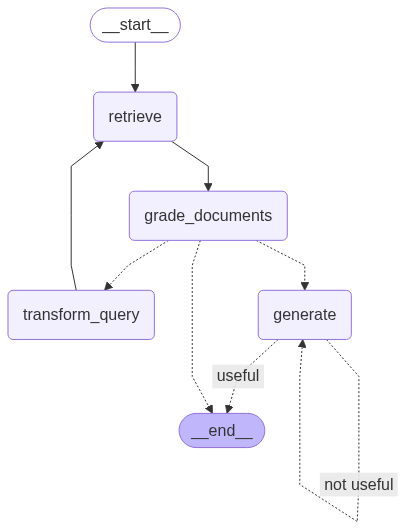

In [196]:
from IPython.display import Image, display

try:
    display(Image(rag_workflow.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [197]:
input_state = {
    "question": "경조사비 알려줘"
}
result = rag_workflow.invoke(input_state)


---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


In [199]:
result['generation']

'경조사비는 결혼, 사망, 출산 등 다양한 경우에 따라 다르게 지급됩니다. 예를 들어, 본인의 결혼 시 500,000원이 지급되며, 사망 시 본인 및 배우자에게는 1,000,000원이 지급됩니다. 출산의 경우 배우자에게 300,000원이 지급됩니다.'